In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.models import load_model
import tensorflow as tf
import keras
from keras.layers import Flatten, Dense, Dropout

In [3]:
data_dir = '/kaggle/input/cat-dog/cat_dog'

csv_file_path = '/kaggle/input/cat-dog-csv/cat_dog.csv'
data_df = pd.read_csv(csv_file_path)

In [4]:
def load_and_preprocess_image(file_path, target_size=(128, 128)):
    img = load_img(file_path, target_size=target_size)
    #chuan hoa ve (0,1)
    img_array = img_to_array(img) / 255.0 
    return img_array

In [5]:
X = np.array([load_and_preprocess_image(os.path.join(data_dir, row['image'])) for index, row in data_df.iterrows()])

In [6]:
y = np.array(data_df['labels'])

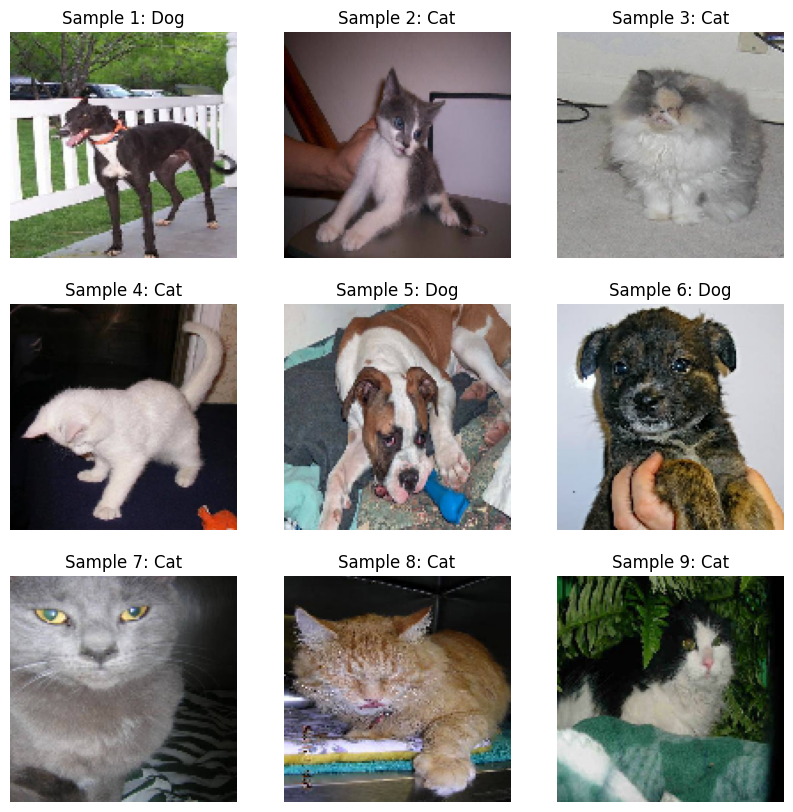

In [8]:
#hien thi mot so mau du lieu
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)  
    plt.imshow(X[i])  
    plt.axis('off')  
    label = 'Cat' if y[i] == 0 else 'Dog' 
    plt.title(f"Sample {i + 1}: {label}")

plt.show()

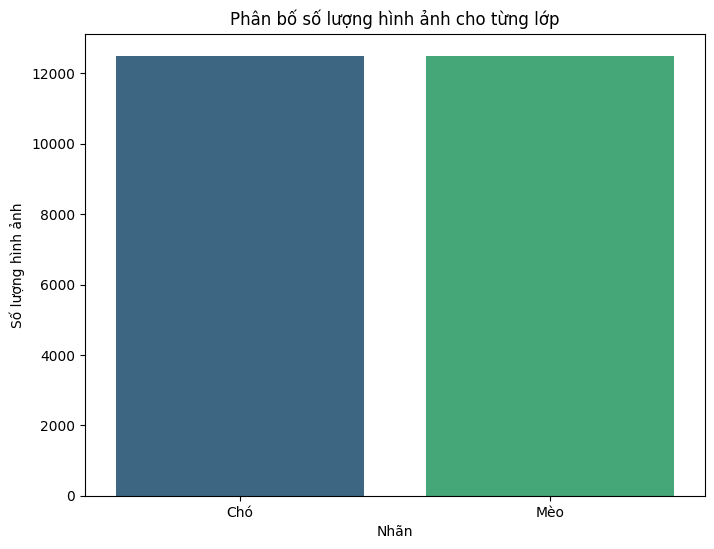

In [9]:
df = pd.DataFrame({'label': y})

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Phân bố số lượng hình ảnh cho từng lớp')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng hình ảnh')
plt.xticks(ticks=[0, 1], labels=['Chó', 'Mèo'])
plt.show()

In [11]:
class_counts = df['label'].value_counts()
print("Số lượng hình ảnh cho từng lớp:")
print(class_counts)

Số lượng hình ảnh cho từng lớp:
label
1    12500
0    12500
Name: count, dtype: int64


In [9]:
print(f"Kích thước: {X.shape}")
print(f"Kích thước: {y.shape}")

Kích thước: (25000, 128, 128, 3)
Kích thước: (25000,)


In [9]:
#lam phang du lieu truoc khi train
n_samples, height, width, n_channels = X.shape
X_flat = X.reshape(n_samples, height * width * n_channels)

print(f"Kích thước của X sau khi làm phẳng: {X_flat.shape}")

Kích thước của X sau khi làm phẳng: (25000, 49152)


In [10]:
#chia tap du lieu
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

In [11]:
#train model bang random forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
y_rf_pred = model_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_rf_pred)
report = classification_report(y_test, y_rf_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

Accuracy: 0.6506
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      2508
           1       0.66      0.61      0.63      2492

    accuracy                           0.65      5000
   macro avg       0.65      0.65      0.65      5000
weighted avg       0.65      0.65      0.65      5000



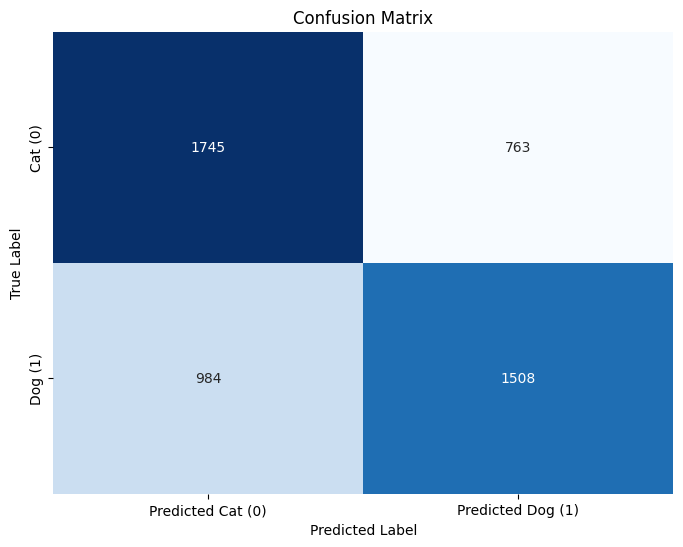

In [13]:
cm = confusion_matrix(y_test, y_rf_pred)

cm_df = pd.DataFrame(cm, index=['Cat (0)', 'Dog (1)'], columns=['Predicted Cat (0)', 'Predicted Dog (1)'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
import joblib
joblib.dump(model_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [15]:
print("X_train shape:", X_train.shape)  
print("X_test shape:", X_test.shape)  


NameError: name 'X_train' is not defined

In [10]:
#train model su dung VGG16

X_vgg_train, X_vgg_test, y_vgg_train, y_vgg_test = train_test_split(X, y, test_size=0.2, random_state=42)

#one hot label
y_vgg_train = to_categorical(y_vgg_train, num_classes=2)
y_vgg_test = to_categorical(y_vgg_test, num_classes=2)

In [11]:
print("X_vgg_train shape:", X_vgg_train.shape) 
print("X_vgg_test shape:", X_vgg_test.shape) 
print("y_vgg_train shape:", y_vgg_train.shape) 
print("y_vgg_test shape:", y_vgg_test.shape) 

X_vgg_train shape: (20000, 128, 128, 3)
X_vgg_test shape: (5000, 128, 128, 3)
y_vgg_train shape: (20000, 2)
y_vgg_test shape: (5000, 2)


In [25]:
#load model VGG16
base_model = VGG16(weights='/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
#model
model_vgg = Sequential([
    base_model,
    Flatten(),  
    Dense(128, activation='relu'), 
    Dropout(0.5), 
    Dense(2, activation='softmax')
])

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg = model_vgg.fit(X_vgg_train, y_vgg_train, validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1844s 7s/step - accuracy: 0.7858 - loss: 0.5171 - val_accuracy: 0.8850 - val_loss: 0.2659
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1831s 7s/step - accuracy: 0.8895 - loss: 0.2594 - val_accuracy: 0.8882 - val_loss: 0.2519
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1896s 7s/step - accuracy: 0.9006 - loss: 0.2354 - val_accuracy: 0.8827 - val_loss: 0.2586
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1842s 7s/step - accuracy: 0.9076 - loss: 0.2177 - val_accuracy: 0.8925 - val_loss: 0.2541
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1872s 7s/step - accuracy: 0.9118 - loss: 0.2121 - val_accuracy: 0.8935 - val_loss: 0.2496


In [28]:
model_vgg.save('model_vgg.h5')

In [23]:
from keras.models import load_model

model_vgg = load_model('/kaggle/input/model_vgg/tensorflow2/model_vgg/1/model_vgg.h5', compile=False)

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(64, 4, 4, 512), dtype=float32, sparse=False, name=keras_tensor_545>'],)
  • kwargs=<class 'inspect._empty'>

In [29]:
test_loss, test_accuracy = model_vgg.evaluate(X_vgg_test, y_vgg_test)
print(f'Test accuracy: {test_accuracy:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.8982 - loss: 0.2466
Test accuracy: 0.9018


In [32]:
y_vgg_pred_prob = model_vgg.predict(X_vgg_test)
y_vgg_pred = np.argmax(y_vgg_pred_prob, axis=1)

y_vgg_test_label = np.argmax(y_vgg_test, axis=1)


157/157 ━━━━━━━━━━━━━━━━━━━━ 453s 3s/step


NameError: name 'y_test_labels' is not defined

In [34]:
report = classification_report(y_vgg_test_label, y_vgg_pred, target_names=['Cat', 'Dog'])

print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

         Cat       0.90      0.90      0.90      2508
         Dog       0.90      0.90      0.90      2492

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



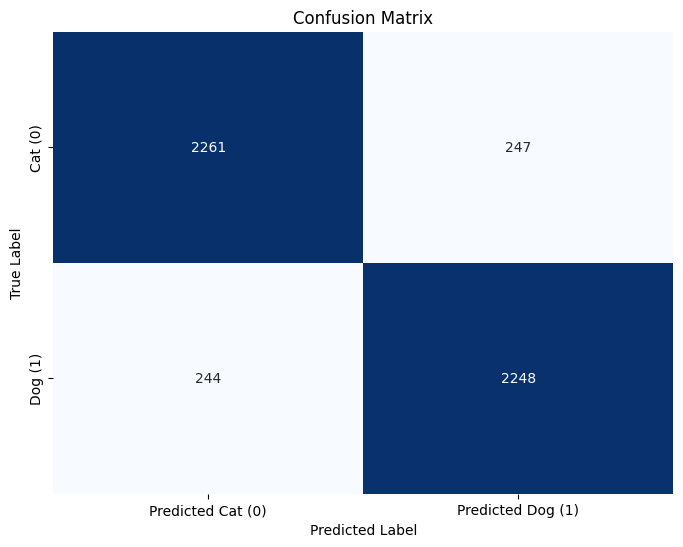

In [36]:
cm = confusion_matrix(y_vgg_test_label, y_vgg_pred)

cm_df = pd.DataFrame(cm, index=['Cat (0)', 'Dog (1)'], columns=['Predicted Cat (0)', 'Predicted Dog (1)'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()